
# Perceptrons

In [716]:
import math
import random
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

def reset_graph(seed=43):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [717]:
iris = load_iris()
X = iris.data[:,(2,3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42)
per_clf.fit(X,y)
y_pred = per_clf.predict([[2,0.5]])
y_pred

/Users/home/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([1])

# Using plain TensorFlow

In [718]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

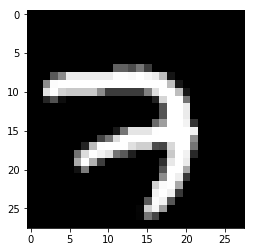

(55000, 784)


In [735]:
plt.imshow((X_train[0].reshape(28,28)))
plt.gray()
plt.show()
print(X_train.shape)

In [649]:
from sklearn.model_selection import train_test_split

def image_label_split(train_data_set, seed=43):
    random.seed(seed)
    random.shuffle(train_data_set)
    labels = np.array(list(map(lambda x:x[0], train_data_set))).astype(np.int32)
    images = (1-np.array(list(map(lambda x:x[1], train_data_set)))).reshape(-1,784)
    return images, labels

with open('/Users/home/disfor/OCR/OCR_System/Sandbox/train_num_data.pkl','rb') as f:
    num_list = pkl.load(f)
    
num_images, num_labels = image_label_split(num_list)
X_train, X_test, y_train, y_test = train_test_split(num_images, num_labels, test_size=0.33, random_state=42)
X_valid = np.r_[X_train, X_test]
y_valid = np.r_[y_train, y_test]

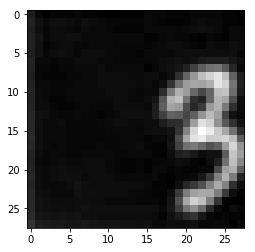

In [650]:
plt.imshow((X_train[0].reshape(28,28)))
plt.gray()
plt.show()

In [720]:
import tensorflow as tf

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


In [721]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}".format(root_logdir, now)

In [722]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")

In [723]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(initial_value=init, name="kernel")
        W = tf.Print(W, [W], message="{}/W is:".format(name))
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        b = tf.Print(b, [b], message="{}/b is:".format(name))
        Z = tf.matmul(X, W) + b
        z = tf.Print(Z, [Z], message="{}/Z is:".format(name))
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [724]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")
    logits_softmax = tf.nn.softmax(logits, name="softmax")

In [725]:
with tf.name_scope("loss"):
    one_hot_label = tf.one_hot(indices=y, depth=n_outputs)
    cross_entropy = -tf.reduce_sum(one_hot_label*tf.log(tf.clip_by_value(logits,1e-10,1.0)))
#     xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(cross_entropy, name="loss")

In [726]:
learning_rate = 0.0001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [727]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [728]:
loss_summary = tf.summary.scalar('loss',loss)
acc_summary = tf.summary.scalar('acc', accuracy)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [729]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [730]:
n_epochs = 40
batch_size = 50

In [731]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X)//batch_size
    for batch_idx in np.array_split(rnd_idx,n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [732]:
sess = tf.Session()
sess.run(init)
for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch},session=sess)
    acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid},session=sess)
    loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid},session=sess)
    loss_summary_str = loss_summary.eval(feed_dict={X:X_valid, y:y_valid},session=sess)
    acc_summary_str = acc_summary.eval(feed_dict={X:X_valid, y:y_valid},session=sess)
    file_writer.add_summary(loss_summary_str, epoch)
    file_writer.add_summary(acc_summary_str, epoch)
    print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val, "Loss:", loss_val)

save_path = saver.save(sess, "./my_model_final.ckpt")
    
file_writer.close()

0 Batch accuracy: 0.4 Val accuracy: 0.3726 Loss: 10643.452
1 Batch accuracy: 0.46 Val accuracy: 0.3626 Loss: 10638.709
2 Batch accuracy: 0.32 Val accuracy: 0.2588 Loss: 1.0358872
3 Batch accuracy: 0.34 Val accuracy: 0.2736 Loss: 0.22887671
4 Batch accuracy: 0.3 Val accuracy: 0.275 Loss: 0.18275973
5 Batch accuracy: 0.34 Val accuracy: 0.2752 Loss: 0.108310424
6 Batch accuracy: 0.32 Val accuracy: 0.2726 Loss: 0.058609277
7 Batch accuracy: 0.28 Val accuracy: 0.2708 Loss: 0.030670827
8 Batch accuracy: 0.14 Val accuracy: 0.2708 Loss: 0.030670827
9 Batch accuracy: 0.24 Val accuracy: 0.2708 Loss: 0.030670827
10 Batch accuracy: 0.16 Val accuracy: 0.2708 Loss: 0.030670827
11 Batch accuracy: 0.24 Val accuracy: 0.2708 Loss: 0.030670827
12 Batch accuracy: 0.24 Val accuracy: 0.2708 Loss: 0.030670827


KeyboardInterrupt: 

In [556]:
sess = tf.Session()
sess.run(init)
for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
    sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch}, session=sess)
    acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}, session=sess)
    xentropy_val = xentropy.eval(feed_dict={X:X_batch, y:y_batch},session=sess)
    loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch},session=sess)
    # loss_summary_str = loss_summary.eval(feed_dict={X:X_valid, y:y_valid})
    # acc_summary_str = acc_summary.eval(feed_dict={X:X_valid, y:y_valid})
    # file_writer.add_summary(loss_summary_str, epoch)
    # file_writer.add_summary(acc_summary_str, epoch)
    print("Batch accuracy:{}, Val accuracy:{}\n, Xentropy:{}, Loss:{}".format(acc_batch, acc_val, xentropy_val,loss_val))
    if math.isnan(loss_val):
        nan_X_batch = X_batch
        nan_y_batch = y_batch
        nan_logit = logits.eval(feed_dict={X:X_batch, y:y_batch}, session=sess)
        break

save_path = saver.save(sess, "./my_model_final.ckpt")
    
file_writer.close()

Batch accuracy:0.3333333432674408, Val accuracy:0.19352634251117706
, Xentropy:[3.3674397  1.5905359  0.8521459  3.4229007  1.2097989  1.7711446
 2.783839   1.9699447  1.4667255  1.591632   0.25885314 1.5339098
 3.2825532  1.8922919  1.383898   2.4292188  1.280846   1.6641984
 2.1796403  2.179112   0.9692587  3.1401553  2.5127285  0.57596785
 2.0923498  0.76977754 1.8379896  5.5985703  1.392161   5.4017124
 2.242055   0.8815097  2.1552775  2.1202865  0.55056727 3.4202297
 0.96559346 1.5197865  0.49532574 1.7150338  4.64835    0.4959902
 1.1436117  1.6439409  1.7670097  3.89254    0.76071906 0.66533035
 2.0993185  0.25570047 1.4476595 ], Loss:1.9075908660888672
Batch accuracy:0.27450981736183167, Val accuracy:0.1342983990907669
, Xentropy:[2.3974345  2.2832923  1.2085657  3.1848931  0.40993863 1.7066187
 2.05134    1.1569947  0.56486666 1.0577265  1.0539567  1.2686472
 1.9456232  3.6681542  2.6825535  3.3648148  1.1268256  1.0545954
 2.6664476  2.8740416  1.7103703  2.8365626  1.8822885

In [471]:
logits.eval(feed_dict={X:X_test, y:y_test}, session=sess)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [427]:
sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch}, session=sess)
acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid}, session=sess)
xentropy_val = xentropy.eval(feed_dict={X:X_batch, y:y_batch},session=sess)
loss_val = loss.eval(feed_dict={X: X_batch, y: y_batch},session=sess)
# loss_summary_str = loss_summary.eval(feed_dict={X:X_valid, y:y_valid})
# acc_summary_str = acc_summary.eval(feed_dict={X:X_valid, y:y_valid})
# file_writer.add_summary(loss_summary_str, epoch)
# file_writer.add_summary(acc_summary_str, epoch)
print("Batch accuracy:{}, Val accuracy:{}\n, Xentropy:{}, Loss:{}".format(acc_batch, acc_val, xentropy_val,loss_val))

Batch accuracy:1.0, Val accuracy:0.21154667437076569
, Xentropy:[2.0893428e-03 7.4158623e-03 8.4911268e-03 2.7436493e-03 0.0000000e+00
 2.2180497e-03 4.2650215e-03 2.1956877e-03 8.6017577e-03 7.4152709e-03
 1.6806300e-03 8.7128486e-03 4.3043073e-02 1.4399446e-04 1.8000441e-05
 6.8247865e-04 1.9502202e-02 4.0877839e-03 6.2034437e-03 4.6252171e-03
 4.4753393e-03 1.3651228e-02 7.8979349e-03 9.2502356e-02 6.8390812e-03
 3.0260745e-03 3.4957973e-04 9.0598651e-06 3.1893600e-03 5.9328168e-03
 7.8580797e-02 1.0246767e-02 1.2326135e-02 1.0358751e-04 5.6167564e-04
 4.6466943e-03 4.4848397e-04 4.6016038e-03 3.5062286e-03 5.1992442e-03
 0.0000000e+00 4.0560844e-03 3.6471060e-03 5.4425634e-03 1.9468300e-02
 2.4135765e-03 2.4402146e-03 6.4036413e-03 5.3023972e-02 3.2737069e-02], Loss:0.010437240824103355


In [473]:
hidden1.eval(feed_dict={X:X_batch, y:y_batch}, session=sess)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [464]:
hoge = 0
for i in y_train:
    hoge += i
hoge

58996

In [647]:
sess = tf.Session()
hoge = tf.one_hot(y_batch, depth=10).eval(session=sess)
hoge[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [640]:
y_batch

array([1, 1, 8, 4, 0, 8, 4, 1, 2, 9, 4, 4, 1, 3, 2, 4, 1, 6, 0, 8, 0, 3,
       3, 5, 7, 8, 8, 9, 8, 4, 3, 5, 6, 3, 4, 8, 2, 5, 4, 1, 4, 1, 4, 2,
       0, 3, 8, 7, 9, 7], dtype=int32)